# Поиск и извлечение фрагментов текста.

**В данной работе стоит задача построения модели машинного обучения для определения и извлечения необходимого фрагмента из текста документа.** 

Определение фрагмента текста необходимо отделу госзакупок компании "******" для формирования анкеты заявки. 

Для выполнения работы у нас есть 2 файла с данными в формате .json - для обучения и тестирования модели. Данные для обучения содержат текст документа и пункт анкеты (один из двух) по которому необходимо определить нужный фрагмент текста. <br>
В данной работе мы, в первую очередь, рассмотрим имеющиеся данные. Изучим в каком виде находится текст документов, в которых необходимо искать фрагменты.
Также рассмотрим возможности улучшения или очистки текста. 

Для выполнения задачи по поиску необходимой части текста будем использовать fine-tuning модели DeBERTaV3 из библиотеки `transformers`, предобученную на датасете SQuAD2.0. Модель обучалась отвечать на вопросы по предоставленному контексту, а также была предобучена на множество языков, в том числе и русский. В качестве контекста для модели, в нашем случае, будет выступать текст имеющегося документа, а в качестве вопроса - пункт анкеты. Для токенизации входного текста будем использовать предобученный токенизатор нашей модели. <br>
После получения предсказаний модели будем проводить анализ результатов и доработку выходных фрагментов текста.

По условиям, работу модели необходимо оценивать по метрике `accuracy`, которая будет считать верным ответом полное, посимвольное совпадение предсказанного фрагмента текста документа с известным ответом. 
Также, ожидается, что модель вместе с извлечением фрагмента текста будет выдавать индексы начала и конца фрагмента в полном документе. 

Итоговые предсказания на тестовом наборе данных необходимо добавить к тестовым данным и сохранить в файл `predictions.json`.

## Загрузка и анализ данных

**Импортируем необходимые библиотеки и загрузим данные. Для наглядного вида данных представим в формате pandas.DataFrame**

In [ ]:
import pandas as pd

pd.options.display.max_colwidth = 150

import numpy as np
import os
import seaborn as sns

import torch
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
)

SEED = 777

In [ ]:
path_main = "/kaggle/input/d/ovouko/text-extract/"  # для работы на kaggle
path_server_train = "https://drive.google.com/u/0/uc?id=1yF_3uPc0kgtsjrc-8Q-4Z0SKrBpbsVAp&export=download"  # для локальной работы
path_server_test = "https://drive.google.com/u/0/uc?id=13z-WWdrLkFubj1EhvRE7fOL6l6At53Op&export=download"  # для локальной работы

In [ ]:
def load(file_name):
    if os.path.exists(path_main):
        return pd.read_json(path_main + file_name)
    elif "train" in file_name:
        return pd.read_json(path_server_train)
    elif "test" in file_name:
        return pd.read_json(path_server_test)
    else:
        print("Check path or file")

In [3]:
full_train_data = load("train.json")
test_data = load("test.json")
full_train_data.shape, test_data.shape

((1799, 4), (318, 3))

In [4]:
full_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1799 non-null   int64 
 1   text            1799 non-null   object
 2   label           1799 non-null   object
 3   extracted_part  1799 non-null   object
dtypes: int64(1), object(3)
memory usage: 56.3+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      318 non-null    int64 
 1   text    318 non-null    object
 2   label   318 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.6+ KB


In [ ]:
full_train_data.sample(n=8, random_state=SEED)

,id,text,label,extracted_part
587,576814118,"УТВЕРЖДАЮ Начальник ГБУ ВО «Урюпинская райСББЖ» _________________ В.Г. Фирсанова ""____"" ________________ 2022 г. М.П. ИЗВЕЩЕНИЕ О ПРОВЕДЕНИИ ЗАПРО...",обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_end': [0]}"
58,896987647,14 V. ПРОЕКТ КОНТРАКТА Государственный контракт г. ____________ «___» ________ 20___ г. краевое государственное казенное учреждение ''Центр социал...,обеспечение исполнения контракта,"{'text': ['Обеспечение исполнения контракта установлено в размере 5,00% от цены контракта на сумму _________ рублей.'], 'answer_start': [1237], 'a..."
581,570842391,"ДОГОВОР ПОСТАВКИ № (ПРОЕКТ) р. п. Белореченский « _____» ​​​​___________ 2022 г. Муниципальное унитарное предприятие «Транзит-аква», именуемое в д...",обеспечение исполнения контракта,"{'text': ['Размер обеспечения исполнения договора составляет 5% начальной (максимальной) цены договора'], 'answer_start': [1250], 'answer_end': [1..."
697,537590924,"Лист изменений ИЗВЕЩЕНИЯ № ЗК-08/12-2022 О ПРОВЕДЕНИИ ЗАПРОСА КОТИРОВОК В ЭЛЕКТРОННОЙ ФОРМЕ, УЧАСТНИКАМИ КОТОРОГО МОГУТ БЫТЬ ТОЛЬКО СУБЪЕКТЫ МАЛОГ...",обеспечение исполнения контракта,"{'text': ['Участник-победитель (далее Поставщик) вносит обеспечение исполнения Договора в размере 3% от начальной (максимальной) цены договора'], ..."
660,378442523,Акционерное общество «Российский концерн по производству электрической и тепловой энергии на атомных станциях» (АО «Концерн Росэнергоатом») Филиал...,обеспечение исполнения контракта,"{'text': ['обеспечение исполнения договора в размере 5 % от цены договора'], 'answer_start': [1273], 'answer_end': [1335]}"
875,477848265,"СОДЕРЖАНИЕ I. ИНФОРМАЦИя о сроках проведения О АУКЦИОНА в электронной форме, УЧАСТНИКАМИ КОТОРОГО МОГУТ БЫТЬ ТОЛЬКО СУБЪЕКТЫ МАЛОГО И СРЕДНЕГО ПРЕ...",обеспечение исполнения контракта,"{'text': ['Размер обеспечения исполнения контракта 5% максимального значения цены договора'], 'answer_start': [1167], 'answer_end': [1246]}"
523,258559234,Утверждаю: Главный врач МБУЗ «ЦГБ» г. Зверево ________________ А.В.Швыгин «05»сентябрь 2022 г. Документация об электронном аукционе Поставка перча...,обеспечение исполнения контракта,"{'text': ['Размер обеспечения исполнения контракта: 5% от цены, по которой заключается контракт'], 'answer_start': [1230], 'answer_end': [1314]}"
301,366674265,Идентификационный код закупки: 222631102500963110100100040070000000 КОНТРАКТ №____ на поставку продуктов питания город ______________ «___»_______...,обеспечение исполнения контракта,"{'text': ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'], 'answer_start': [12..."


____
Для обучения модели мы имеем датасет в котором 1799 строк и 4 столбца. В столбце `text` находятся текстовые документы, из которых нужно извлекать фрагмент, а в столбце `label` пункт анкеты который определяет основу искомого фрагмента. <br>
Столбец `id` определяет уникальный номер документа.<br>
В столбце `extracted_part` определена разметка ответов, которые необходимо получать на выходе из модели - на каждый документ мы получаем словарь со следующими наборами:
- `text` - текс требуемого фрагмента текста;
- `answer_start` - индекс начала фрагмента в полном тексте документа;
- `answer_end` - индекс конца фрагмента в полном тексте документа.
_____

**Посмотрим отдельно на примеры требуемых текстовых фрагментов и на сами документы целиком.**

In [7]:
[row["text"] for row in full_train_data.extracted_part[290:350:3]]

[['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'],
 ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'],
 ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'],
 ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'],
 ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'],
 ['Обеспечение исполнения Контракта устанавливается в размере 5 процентов от Цены Контракта.'],
 ['Размер обеспечения исполнения контракта 491652.00 Российский рубль'],
 ['Размер обеспечения исполнения контракта 806.93 Российский рубль'],
 ['Обеспечение исполнения Контракта устанавливается в размере 5 % (Пять) от цены Контракта'],
 ['Обеспечение исполнения настоящего Контракта установлено в размере 5 %

In [8]:
full_train_data.text[300:320:3].values

array(['Идентификационный код закупки: 222633005064263300100100330011051244 КОНТРАКТ №____ на поставку продуктов питания город ______________ «___»__________ 20__ год государственное бюджетное общеобразовательное учреждение Самарской области средняя общеобразовательная школа № 10 городского округа Чапаевск Самарской  который является казенным учреждением; 2) осуществления закупки услуги по предоставлению кредита; 3) заключения бюджетным учреждением, государственным, муниципальным унитарными предприятиями контракта, предметом которого является выдача независимой гарантии. Заказчик вправе установить, что настоящий раздел не применяется в случае заключения Контракта по результатам проведения электронного запроса котировок (за исключением случая, предусмотренного подпунктом "б" пункта 2 части 10 статьи 24 Федерального закона «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд»). По контрактам, подлежащим казначейскому сопровожде

______
При внимательном рассмотрении полного текста документов можно заметить следующие вещи:
- Текс документов содержит в себе обрывки из юридических текстовых документов (договоров, извещений, проектов и т.д.);
- В данных отрывках включены тексты заголовков, ссылки, нумерованные списки, аббревиатуры, табуляция, пустые поля для заполнения, цифры;
- Целая и дробная части цифр в различных документах могут быть раз разделены различными символами;
- Предложения не всегда заканчиваются точками, иногда они просто разделены пробелами;
- Большинство документов составлено на русском языке, однако встречаются и английские символы;
- Заглавные буквы в общем случае определяют начала предложений, но также определяют юридические обращения, аббревиатуры, имена собственные и прочие слова;
- Дублирование пробелов не замечено.

При детальном рассмотрении фрагментов текста, которые необходимо определить, выясняются следующие моменты:
- Порадок слов и окончания из ключевой фразы (пункта анкеты) не всегда сохраняются в целевых фрагментах;
- Не во всех документах присутствует искомый фрагмент. В таких случаях в поле `extracted_part["text"]` идет пустая строка, а в полях `extracted_part["answer_start"]` и `extracted_part["answer_end"]` стоит ноль;
- В целом искомые отрезки похожи на цельные предложения, некоторые из которых обрезаны с конца;
- Размеры фрагментов текста различаются в зависимости от контекста;
- В искомых отрывках могут присутствовать слова русского языка, дробные и целые числа, различные символы;
- Большая часть отрывков начинается со слова с заглавной буквой;
- Некоторые отрывки заканчиваются точкой, а у некоторых окончание не говорит о том, что предложение в исходном тексте закончено.
_____

**Чтобы детальнее посмотреть на символы с которых начинаются и заканчиваются искомые фрагменты выведем символы начала и конца этих кусочков текста.**

In [9]:
print("Символы, с которых начинаются искомые отрезки текста и частота их повторов:")
pd.value_counts(
    [
        x[full_train_data.iloc[i]["extracted_part"]["answer_start"][0]]
        for i, x in enumerate(full_train_data.text)
        if full_train_data.iloc[i]["extracted_part"]["answer_start"][0] != 0
    ]
)

Символы, с которых начинаются искомые отрезки текста и частота их повторов:


Р    912
О    264
П     81
С     33
н     30
о     29
п     16
У     14
З     14
В     14
Е     13
д     12
т      8
И      8
в      6
Т      6
р      6
у      5
Н      4
к      4
с      3
е      2
       2
Г      2
Ф      1
Д      1
з      1
«      1
dtype: int64

In [10]:
print("Символы, которыми заканчиваются искомые отрезки текста и частота их повторов:")
pd.value_counts(
    [
        x[full_train_data.iloc[i]["extracted_part"]["answer_end"][0]]
        for i, x in enumerate(full_train_data.text)
        if full_train_data.iloc[i]["extracted_part"]["answer_end"][0] != 0
    ]
)

Символы, которыми заканчиваются искомые отрезки текста и частота их повторов:


     1215
,     196
_      30
/      11
.      10
;      10
:       3
л       3
)       2
[       2
р       2
-       2
(       2
3       1
у       1
о       1
Т       1
dtype: int64

_____
Видно, что отрывки текста в большинстве случаев начинаются на заглавные буквы. Таким образом, можно предположить, что символом, предшествующем первому символу, является пробел (в большей части случаев).<br>
Также символом окончания отрезков текста в большинстве случаев является пробел, в более редких случаях символ запятой.<br>
Таким образом, можно утверждать, что в большинстве случав искомый отрезок текста не разрывает слова, а целиком вмещает в себя начальное и конечное слово.<br>
На основании этого можно также предположить, что в разметке были редкие ошибки, и довести модель до 100% результата будет невозможно.
_____

**Теперь рассмотрим в каком колличестве распределены искомые пункты анкеты в наших документах. При распределении не будем учитывать тексты, не имеющие искомого пункта.**

Для дальнейшего удобства добавим в тренировочный датасет столбец `status`, который будет показывать либо отсутствие в тексте искомого фрагмента, либо пункт анкеты из столбца `label`

In [11]:
full_train_data["status"] = [
    "нет фрагмента" if x["text"] == [""] else full_train_data.label.iloc[i]
    for i, x in enumerate(full_train_data.extracted_part)
]

full_train_data.tail()

,id,text,label,extracted_part,status
1794,938335285,"«УТВЕРЖДАЮ» Директор МУП ""ПКП и ОРТ"" _________________/ А.И. Бибиков / «01» сентября 2022 г ИЗВЕЩЕНИЕ О ПРОВЕДЕНИИ ЗАПРОСА КОТИРОВОК В ЭЛЕКТРОННОЙ...",обеспечение гарантийных обязательств,{'text': ['Заказчиком установлено требование обеспечения исполнения договора и (или) обеспечения исполнения гарантийных обязательств. 5% от началь...,обеспечение гарантийных обязательств
1795,214609521,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ «ПРОИЗВОДСТВЕННОЕ ОБЪЕДИНЕНИЕ «МАЯК» УТВЕРЖДАЮ Председатель Единой закупочной комиссии _________...,обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_end': [0]}",нет фрагмента
1796,94811748,"ДОГОВОР ПОДРЯДА № _____ «___»___________20____г. ПАО «Россети Северо-Запад», именуемое в дальнейшем «Заказчик», в лице _______________________, де...",обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_end': [0]}",нет фрагмента
1797,903507299,ДОКУМЕНТАЦИЯ О ЗАКУПКЕ ЗАПРОС ПРЕДЛОЖЕНИЙ В ЭЛЕКТРОННОЙ ФОРМЕ на право заключения договора на оказание услуг по оценке эффективности функционирова...,обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_end': [0]}",нет фрагмента
1798,926039184,Государственная корпорацИя по атомной энергии «росатом» акционерное общество «НИИЭФА им. Д.В. Ефремова» (АО «НИИЭФА») УТВЕРЖДАЮ: Генеральный дирек...,обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_end': [0]}",нет фрагмента


In [12]:
print("Количественное распределение текстов в датасете по искомому пункту анкеты:")
full_train_data.status.value_counts()

Количественное распределение текстов в датасете по искомому пункту анкеты:


обеспечение исполнения контракта        984
обеспечение гарантийных обязательств    508
нет фрагмента                           307
Name: status, dtype: int64

____
Здесь мы видим некоторый дисбаланс в количестве примеров разного класса по столбцу `label`. Больше всего в наличии примеров с `label` = 'обеспечение исполнения контракта'. При этом примеров без искомого фрагмента меньше 20% - для модели это не должно стать проблемой, так как на каждый отсутствующий фрагмент ответ одинаковый. 
____

**Также посмотрим на распределение длин текстов для каждого искомого класса в символах.**

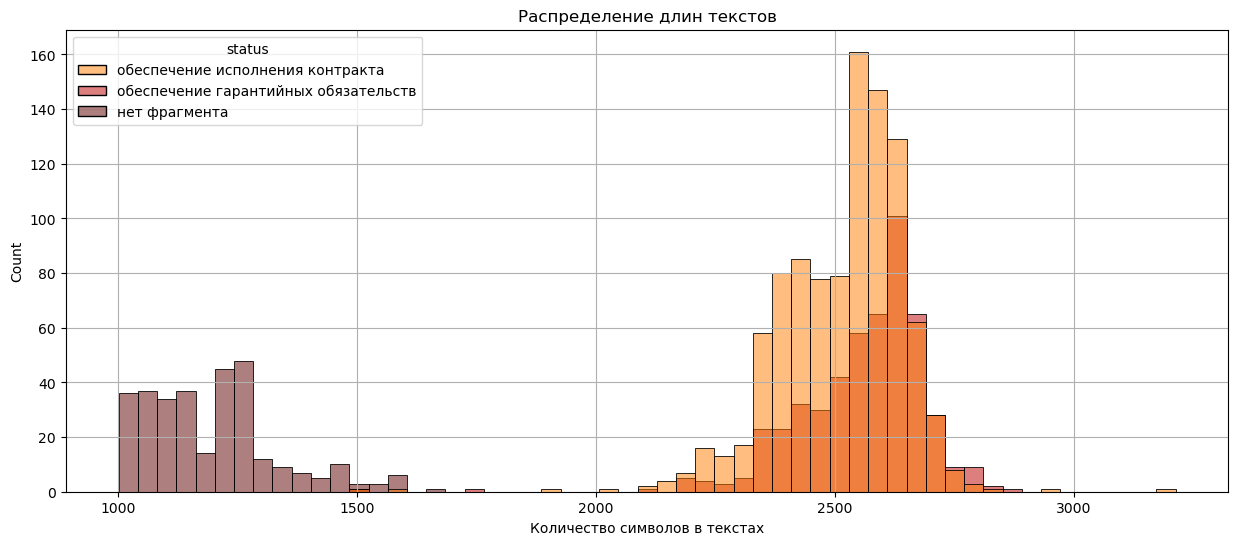

In [13]:
ax = sns.histplot(
    full_train_data,
    x=[len(x) for x in full_train_data.text],
    hue="status",
    palette="gist_heat_r",
)

ax.set(
    xlabel="Количество символов в текстах",
    title="Распределение длин текстов",
)
ax.grid()
ax.figure.set_figheight(6)
ax.figure.set_figwidth(15)

_____
По данному графику можно заметить, что длины текстов, в которых отсутствует искомый фрагмент текста сильно отличается по количеству символов от остальных текстов - такие тексты имеют максимальное количество символов не более $\approx$ 1700. Длины текстов с наличием искомых фрагментов находятся в диапазоне $\approx$ 2000 - 3000 символов и но длине друг от друга особо не отличаются. Длины текстов в различных классах по столбцу `label` не отличаются.
_____

**По результатам анализа имеющихся данных, можно добавить, что текста документов содержат много различных символов и слов, иногда не относящихся к смысловой составляющей документа. Также видно, что многие символы попадают и в целевые фрагменты текста. Регистр слов в текстах имеет некоторый порядок, хотя не без исключений. При этом требуемые фрагменты текста в большинстве своем начинаются именно с заглавных букв, а также могут содержать ключевую фразу (пункт анкеты) разделенную другими словами или имеющую символьное отличие (окончания). Учитывая все это, принимаем решение не заниматься очисткой текста и позволим модели найти существующие паттерны для поиска необходимых частей текста.**

## Разделение данных и подготовка модели

Чтобы оценивать работу нашей модели разделим наши данные на обучающую часть и валидационную. Так как мы имеем ограниченное количество данных, возьмем 15% данных для валидации модели. Данные среди выборок распределим равномерно относительно столбца `label`, чтобы в обоих частях имелись все виды классов предсказаний.

In [ ]:
train_data, valid_data = train_test_split(
    full_train_data,
    test_size=0.15,
    shuffle=True,
    stratify=full_train_data.status,
    random_state=SEED,
)

print(
    "Распределение классов в обучающей выборке:",
    "\n",
    train_data.status.value_counts(),
    "\n",
    "\n",
    "Распределение классов в валидационной выборке:",
    "\n",
    valid_data.status.value_counts(),
)

Распределение классов в обучающей выборке: 
 обеспечение исполнения контракта        836
обеспечение гарантийных обязательств    432
нет фрагмента                           261
Name: status, dtype: int64 
 
 Распределение классов в валидационной выборке: 
 обеспечение исполнения контракта        148
обеспечение гарантийных обязательств     76
нет фрагмента                            46
Name: status, dtype: int64


**Теперь загрузим модель с которой будем работать и токенизатор**

Для выполнения задачи будем использовать fine-tuning модели DeBERTaV3 из библиотеки `transformers`. Модель была обучена на датасете SQuAD2.0, в нем модель училась отвечать на вопросы по предоставленному контексту. Задача ответов на вопросы по контексту похожа на нашу задачу по поиску фрагмента текста в полном документе, имея контрольную фразу (пункт анкеты). Для токенизации текста будем использовать tokenizer также предварительно обученный с этой моделью.<br>
Модель на вход будет принимать датасет с токенизированным полным текстом документа, и токенизированную контрольную фразу. Для дообучения мы будем передавать модели правильные ответы в виде индексов токенов начала и конца нужного фрагмента текста. На выходе модель будет учиться выдавать необходимый фрагмент по индексам начала и конца фразы с учетом полного текста документа (контекста) и контрольной фразы (пункта анкеты).<br>

Для оценки модели по предсказанным индексам будем находить в полном тексте документа фрагмент и сравнивать его с размеченным интервалом текста из столбца `extracted_part`. Полное совпадение фрагментов будет означать успех, частичное или полное несовпадение - ошибка. По этим данным будем вычислять метрику accuracy на валиданной части данных.


Для начала загрузим и определим нашу модель и токенизатор.

In [15]:
tokenizer = AutoTokenizer.from_pretrained("timpal0l/mdeberta-v3-base-squad2")

model = AutoModelForQuestionAnswering.from_pretrained(
    "timpal0l/mdeberta-v3-base-squad2"
)

**Создадим объекты класса `tokenizer` для токенизации отдельно обучающих и валидационных данных.**

In [16]:
max_length = 800


def to_token(data):
    encoder = tokenizer(
        list(data.text),
        list(data.label),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    return encoder

In [17]:
train_encoder = to_token(train_data)
valid_encoder = to_token(valid_data)

Посмотрим на пример работы токенизатора при разделении текста на токены:

In [18]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(
    train_data.text[6][1360:1580]
)

[('▁%', (0, 2)),
 ('▁до', (2, 5)),
 ('▁30', (5, 8)),
 ('▁%', (8, 10)),
 ('▁начальной', (10, 20)),
 ('▁(максимальной)', (20, 35)),
 ('▁цены', (35, 40)),
 ('▁контракта', (40, 50)),
 ('▁с', (50, 52)),
 ('▁учетом', (52, 59)),
 ('▁особенностей,', (59, 73)),
 ('▁указанных', (73, 83)),
 ('▁в', (83, 85)),
 ('▁части', (85, 91)),
 ('▁6', (91, 93)),
 ('▁статьи', (93, 100)),
 ('▁96', (100, 103)),
 ('▁и', (103, 105)),
 ('▁за', (105, 108)),
 ('▁исключением', (108, 120)),
 ('▁случаев,', (120, 129)),
 ('▁предусмотренных', (129, 145)),
 ('▁частями', (145, 153)),
 ('▁6.1.', (153, 158)),
 ('▁и', (158, 160)),
 ('▁6.2', (160, 164)),
 ('▁статьи', (164, 171)),
 ('▁96', (171, 174)),
 ('▁Федерального', (174, 187)),
 ('▁закона', (187, 194)),
 ('▁«О', (194, 197)),
 ('▁контрактной', (197, 209)),
 ('▁системе', (209, 217)),
 ('▁в', (217, 219)),
 ('▁', (219, 220))]

Видно, что прописные буквы и пробелы остаются и будут учтены, также такие символы как цифры (целые и дробные), проценты, кавычки и пр.

**Теперь переведем индексы границ целевых фрагментов текстов в индексы токенов для подачи на вход в модель при обучении.**

In [19]:
def borders_to_token(encodings, answers):
    start_borders = []
    end_borders = []
    for i in range(len(answers)):
        if answers[i]["answer_start"][0] == 0:
            start_borders.append(0)
            end_borders.append(0)
        else:
            start_borders.append(
                encodings.char_to_token(i, answers[i]["answer_start"][0])
            )
            end_borders.append(encodings.char_to_token(i, answers[i]["answer_end"][0]))

    encodings.update({"start_positions": start_borders, "end_positions": end_borders})

In [20]:
borders_to_token(train_encoder, list(train_data.extracted_part))

**Переведем тренировочные и валидационные данные в объекты класса `torch.utils.data.Dataset` для возможности работы с моделью.**

In [21]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [22]:
train_dataset = TextDataset(train_encoder)
valid_dataset = TextDataset(valid_encoder)

**Подготовим объект TrainingArguments с параметрами предстоящего обучения модели.**

In [23]:
training_args = TrainingArguments(
    "results",
    do_eval=False,
    learning_rate=5e-5,
    warmup_steps=50,
    save_strategy="epoch",
    weight_decay=0.02,
    per_device_train_batch_size=4,
    num_train_epochs=4,
    logging_strategy="epoch",
    report_to="none",
)

**Напишем собственный сабкласс Trainer_QA для возможности валидации и тестирования модели на наших условиях.**

In [24]:
class Trainer_QA(Trainer):
    """Класс Trainer_QA является сабклассом от класса transformers.Trainer.
    Реализован метод .evaluate() для валидации модели, получения предсказаний и
    подсчета метрики accuracy путем сравнение размеченного фрагмента текста
    с фрагментом текста полученного из предсказанных токенов начала и конца фрагмента.
    Реализован метод .testing() для получения предсказаний из тестовых данных в формате списка
    словарей с ключами 'text', 'answer_start' и 'answer_end'"""

    def evaluate(self, valid_data, context, target):
        self.predictions, _, _ = self.predict(valid_data)
        start_logits, end_logits = self.predictions

        true_start_logs = np.argmax(start_logits, axis=-1)
        true_end_logs = np.argmax(end_logits, axis=-1)
        self.text = self.__text_from_logs(
            true_start_logs, true_end_logs, context, valid_data
        )
        self.clean_predictions = self.__clean_predic_from_text(self.text, context)
        self.accuracy = sum(
            self.text[i]["text"][0] == target.iloc[i]["text"][0]
            for i in range(len(self.text))
        ) / len(self.text)
        print(f"Accuracy score on validation data = {self.accuracy}")
        return self.accuracy, self.clean_predictions

    def testing(self, test_data, test_context):
        self.test_predictions, _, _ = self.predict(test_data)
        test_start_logits, test_end_logits = self.test_predictions

        test_true_start_logs = np.argmax(test_start_logits, axis=-1)
        test_true_end_logs = np.argmax(test_end_logits, axis=-1)
        self.test_text = self.__text_from_logs(
            test_true_start_logs, test_true_end_logs, test_context, test_data
        )
        self.test_clean_predictions = self.__clean_predic_from_text(
            self.test_text, test_context
        )
        print("Finished predict")
        return self.test_clean_predictions

    def __text_from_logs(self, left_logs, right_logs, context, data):
        text = []
        for i in range(len(left_logs)):
            if right_logs[i] == 0:
                text.append({"text": [""]})
            else:
                text.append(
                    {
                        "text": [
                            context.iloc[i][
                                data.encodings.token_to_chars(i, left_logs[i])[
                                    0
                                ] : data.encodings.token_to_chars(i, right_logs[i])[0]
                            ].strip()
                        ]
                    }
                )
        return text

    def __clean_predic_from_text(self, text, context):
        clean_predict = []
        for i in range(len(text)):
            start_idx = context.iloc[i].find(text[i]["text"][0])
            clean_predict.append(
                {
                    **text[i],
                    "answer_start": [start_idx],
                    "answer_end": [start_idx + len(text[i]["text"][0])],
                }
            )
        return clean_predict

Подготовка завершена, можно приступать к обучению.

## Обучение модели и валидация

Для начала создадим объект класса Trainer_QA и передадим в него параметры, модель и обучающие данные.<br>
Затем запустим обучение.

In [25]:
text_trainer = Trainer_QA(model=model, args=training_args, train_dataset=train_dataset)

In [26]:
text_trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
192,0.972600
384,0.318500
576,0.201200
768,0.120500


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=768, training_loss=0.40321502337853116, metrics={'train_runtime': 1140.8882, 'train_samples_per_second': 5.361, 'train_steps_per_second': 0.673, 'total_flos': 2497062223603200.0, 'train_loss': 0.40321502337853116, 'epoch': 4.0})

Обучение успешно завершено, проверим работу модели на валидационной выборке и посмотрим на результат.

In [27]:
eval_data = text_trainer.evaluate(
    valid_data=valid_dataset, context=valid_data.text, target=valid_data.extracted_part
)
eval_score, eval_predictions = eval_data

Accuracy score on validation data = 0.8555555555555555


In [28]:
eval_predictions[:5]

[{'text': ['Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 5,00 % от цены Контракта.'],
  'answer_start': [1220],
  'answer_end': [1353]},
 {'text': ['Размер обеспечения исполнения контракта 5.00%'],
  'answer_start': [1265],
  'answer_end': [1310]},
 {'text': ['Обеспечение исполнения Контракта устанавливается в размере 5% цены контракта, что составляет ____________ ('],
  'answer_start': [1215],
  'answer_end': [1322]},
 {'text': [''], 'answer_start': [0], 'answer_end': [0]},
 {'text': ['Размер обеспечения гарантийных обязательств: 0,00 рублей.'],
  'answer_start': [1236],
  'answer_end': [1293]}]

In [29]:
list(valid_data.extracted_part[:5])

[{'text': ['Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 5,00 % от цены Контракта.'],
  'answer_start': [1220],
  'answer_end': [1353]},
 {'text': ['Размер обеспечения исполнения контракта 5.00%'],
  'answer_start': [1265],
  'answer_end': [1310]},
 {'text': ['Обеспечение исполнения Контракта устанавливается в размере 5% цены контракта, что составляет ____________ (_____________)'],
  'answer_start': [1215],
  'answer_end': [1336]},
 {'text': [''], 'answer_start': [0], 'answer_end': [0]},
 {'text': ['Размер обеспечения гарантийных обязательств: 0,00 рублей.'],
  'answer_start': [1236],
  'answer_end': [1293]}]

_____
Можно видеть, что модель справилась с валидационными данными достаточно неплохо, оценка `accuracy` = 0,8556. Также, в сравнении с размечеными данными, можно сказать, что при верном определении отрывка текста индексы тоже определены верно и соответствуют индексам в разметке. <br>
**Таким образом мы получили модель, которая справляется с поставленной задачей с некоторой погрешностью, около 14%**
____

## Получение предсказаний на тестовых данных

Приведем тестовые данные к нужному формату и получим предсказания в нашей модели и посмотрим на них.

In [30]:
test_encoder = to_token(test_data)
train_dataset = TextDataset(test_encoder)

In [31]:
test_predict = text_trainer.testing(train_dataset, test_data.text)

Finished predict


In [32]:
test_predict[:7]

[{'text': ['Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).'],
  'answer_start': [1283],
  'answer_end': [1393]},
 {'text': ['Размер обеспечения исполнения контракта 10.00%'],
  'answer_start': [1291],
  'answer_end': [1337]},
 {'text': ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'],
  'answer_start': [1300],
  'answer_end': [1412]},
 {'text': ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'],
  'answer_start': [1312],
  'answer_end': [1424]},
 {'text': ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'],
  'answer_start': [1314],
  'answer_end': [1426]},
 {'text': ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'],
  'answer_start': [1304],
  'answer_end': [14

Предсказания получены и выглядят весьма правдоподобно

Добавим предсказания модели к начальным данным для теста и сохраним в отдельный файл `predictions.json`

In [33]:
test_predictions = pd.concat(
    [test_data, pd.Series(test_predict, name="extracted_part")], axis=1
)
test_predictions.head()

,id,text,label,extracted_part
0,762883279,"МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и вос...",обеспечение исполнения контракта,"{'text': ['Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).'], 'answer_start': [1283..."
1,311837655,Извещение о проведении электронного аукциона для закупки №0124200000622005291 Общая информация Номер извещения 0124200000622005291 Наименование об...,обеспечение исполнения контракта,"{'text': ['Размер обеспечения исполнения контракта 10.00%'], 'answer_start': [1291], 'answer_end': [1337]}"
2,540954893,Идентификационный код закупки: 222633005300163300100100290010000244 КОНТРАКТ №____ на поставку продуктов питания город ______________ «___»_______...,обеспечение исполнения контракта,"{'text': ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'], 'answer_start': [13..."
3,274660397,Идентификационный код закупки: 222631202689463120100100050190000244 КОНТРАКТ №____ на поставку продуктов питания город ______________ «___»_______...,обеспечение исполнения контракта,"{'text': ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'], 'answer_start': [13..."
4,732742591,Идентификационный код закупки: 222637800031163750100100060330000244 КОНТРАКТ №____ на поставку продуктов питания город ______________ «___»_______...,обеспечение исполнения контракта,"{'text': ['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта'], 'answer_start': [13..."


In [34]:
test_predictions.to_json(
    "predictions.json", indent=2, orient="records", force_ascii=False
)

## Выводы

**Модель для определения и извлечения необходимого фрагмента из текста документа была получена, ее работа проверена на валидации**

В работе мы внимательно осмотрели имеющиеся данные, нашли некоторые закономерности и ограничения в вопросах очистки текста и поиска целевых фрагментов.<br>
Далее данные пришлось разделить, чтобы иметь возможность оценивать модели, и подготовить к загрузке в модель.<br>
Затем мы успешно настроили модель DeBERTaV3 из библиотеки `transformers` на поиск фрагментов текста в требуемых документах.<br>
Не смотря на все сложности, модель достигла оценки `accuracy` = 0,8556 на валидационных данных. <br>
Таким образом, мы имеем готовую обученную модель для решения поставленной задачи и ждем результатов ее контрольного тестирования.
